In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fanalysis
from fanalysis.mca import MCA

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [4]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [5]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, dtype=str )#, dtype='Int64')


In [6]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1219999, 23)

In [7]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,000000010010000001,02,81,08,91,09,06,21,21,01,71,41,07,04,12,04,20,02,02,01,51,05,1
1,000000020010000006,01,75,07,43,04,06,06,13,02,71,64,07,06,12,09,04,12,04,13,12,01,1
2,000000030010000011,01,76,07,43,04,06,06,16,03,54,81,05,08,07,12,06,06,04,18,36,03,2
3,000000040010000013,03,75,07,43,04,04,06,13,01,71,36,07,03,12,11,11,19,04,06,21,02,1
4,000000050010000015,02,33,03,44,04,06,07,12,01,71,42,07,04,12,05,14,03,03,01,14,01,2


In [8]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    colonnes = tableau_corr.columns
    val_temp = 0 
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
                val_temp += 1

            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
                val_temp += 1
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0
    if val_temp == 0:
        print("IL N'Y A PAS DE CORRELATION ENTRE LES VARIABLES PAR RAPPORT AU SEUIL PRIS")
        

def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train)))  
    print(classification_report(y_train, model.predict(X_train) ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def vingtiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne Top_mon :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data

    

In [9]:
nombre_mod(data)

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,1219999,1219999
1,TypeHabi,4,4
2,GeoFaz_Scl,38,38
3,GeoFaz_cl,8,8
4,ImmoFaz_Scl,31,31
5,ImmoFaz_cl,9,9
6,Anciennete,11,11
7,Logement_prix_m2,21,21
8,Mediane_RFR,21,21
9,Sexe,5,5


In [10]:
data["Top_mon"].value_counts(dropna=False)

NaN    1092884
2       103659
1        23456
Name: Top_mon, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219999 entries, 0 to 1219998
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1219999 non-null  object
 1   TypeHabi            1219999 non-null  object
 2   GeoFaz_Scl          1219999 non-null  object
 3   GeoFaz_cl           1219999 non-null  object
 4   ImmoFaz_Scl         1219999 non-null  object
 5   ImmoFaz_cl          1219999 non-null  object
 6   Anciennete          1219999 non-null  object
 7   Logement_prix_m2    1219999 non-null  object
 8   Mediane_RFR         1219999 non-null  object
 9   Sexe                1219999 non-null  object
 10  Prenom_Phase_scl_H  1219999 non-null  object
 11  Prenom_Phase_scl_F  1219999 non-null  object
 12  Prenom_Phase_cl_H   1219999 non-null  object
 13  Prenom_Phase_cl_F   1219999 non-null  object
 14  Age_H               1219999 non-null  object
 15  Age_F               1219999 non-

In [12]:
############################################################### AJOUTER OU EFFACER (data =) #######################################
# on élimine les variables corr
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)


In [13]:
num_var_max = data.shape[1] - 1
num_var_max

15

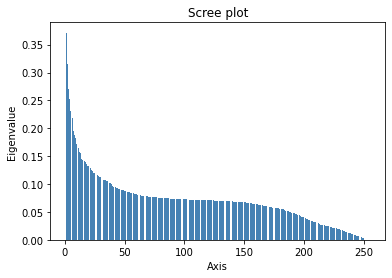

None


In [14]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:num_var_max])

# apprentissage
acm.fit(data.iloc[:127115,1:num_var_max].values)
#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [15]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:num_var_max].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:num_var_max].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:num_var_max].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [16]:
#instanciation
acm = MCA(var_labels = data.columns[1:num_var_max], n_components=100)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
acm.fit(data.iloc[:127115,1:num_var_max].values)

# tranformation du dataset
coord = transform_to_coord(data)


In [17]:
# dimension
coord.shape

(1219999, 100)

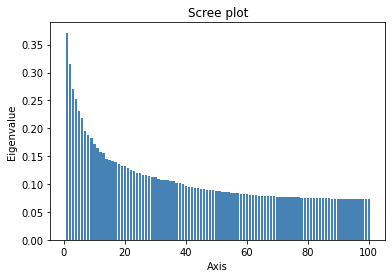

None


In [18]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [19]:
#coordonnées des colonnes
print(acm.col_topandas())

                     col_coord_dim1  col_coord_dim2  col_coord_dim3  \
TypeHabi_01                0.328441       -0.201417        0.223749   
TypeHabi_02               -0.143567        0.074169       -0.091876   
TypeHabi_03                0.136197       -0.000884        0.047311   
TypeHabi_04                0.058198       -0.737083        1.988520   
GeoFaz_Scl_11             -0.122568       -0.004153        0.081375   
...                             ...             ...             ...   
Potentiel_prenom_17       -1.288291        0.051224       -0.866692   
Potentiel_prenom_18       -1.148183        0.040895       -0.256930   
Potentiel_prenom_19       -1.246651        0.016201        0.821046   
Potentiel_prenom_20       -1.141801        0.022557        1.248943   
Potentiel_prenom_21        0.308138       -5.969901       -0.508811   

                     col_coord_dim4  col_coord_dim5  col_coord_dim6  \
TypeHabi_01               -0.255346        0.196996       -0.219208   
TypeH

In [20]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


15
[[ 3.59309123e-02 -2.39199727e-02  2.86685910e-02 ...  1.98287086e-02
   3.47465580e-03  1.15059848e-02]
 [-1.57060041e-02  8.80819897e-03 -1.17719599e-02 ... -1.86543376e-04
   1.25763779e-03  1.29627738e-03]
 [ 1.48997091e-02 -1.04952469e-04  6.06181284e-03 ... -4.06938254e-02
  -1.45242679e-02 -3.04682575e-02]
 ...
 [-1.36381364e-01  1.92394723e-03  1.05199151e-01 ...  6.96158367e-03
   3.26948676e-02  1.18162069e-02]
 [-1.24910962e-01  2.67886812e-03  1.60024836e-01 ...  2.64338557e-03
  -9.05677408e-03 -1.22761441e-02]
 [ 3.37097482e-02 -7.08975837e-01 -6.51930632e-02 ...  7.47849225e-03
   3.83099418e-03 -7.31519271e-03]]
                           0         1         2         3         4   \
TypeHabi_01          0.035931 -0.023920  0.028669 -0.033839  0.027299   
TypeHabi_02         -0.015706  0.008808 -0.011772  0.012781 -0.010957   
TypeHabi_03          0.014900 -0.000105  0.006062 -0.003174  0.004302   
TypeHabi_04          0.006367 -0.087535  0.254786  0.073725  0.249701

In [21]:
# affichafe des 10 premières lignes
print(coord[:2,:])


[[ 9.08979382e-01 -2.05119427e-01  1.57517015e+00 -3.05136158e-01
   1.53599785e+00 -1.20008100e-01 -4.73799717e+00 -2.42533702e-01
   3.87945315e-02 -1.50274363e-01 -3.55785423e-01 -4.49972520e-01
   1.85255749e-02  6.96443586e-01  3.24777282e-01  1.30102309e+00
   4.52032263e-01 -5.83384593e-01  1.08478743e-01 -2.95884655e-01
  -6.17258467e-01 -1.68785502e-01 -1.46199393e-01  7.57290088e-02
   3.70639417e-01  7.61341295e-01  2.71984855e-01 -1.63252762e-01
   4.37907877e-01 -1.19949123e+00  7.78940558e-01  5.89571365e-01
   1.54807128e+00  5.77616687e-01  7.90790784e-01  1.20992298e+00
   3.47589010e-01 -1.36674090e-01  1.20771278e+00  1.09098986e+00
   7.53721276e-01  7.42681797e-01  1.41070580e+00  4.49963544e-01
  -9.77015548e-01 -6.65407324e-01  2.21706266e-01 -6.08697102e-01
  -6.81041353e-01 -5.58085158e-01  8.17501657e-02  2.94912217e-02
   8.00669833e-02  4.65015351e-01  2.55866021e-01  5.23220346e-01
  -1.33097022e-01  2.18734148e-01  2.36644192e-01  2.26232335e-01
   4.69754

In [22]:
#print(data_sans_nan.shape)
#print(coord_sans_nan.shape)
#print(data_sans_nan.iloc[:,0])
#dfff.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219999 entries, 0 to 1219998
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1219999 non-null  object
 1   TypeHabi            1219999 non-null  object
 2   GeoFaz_Scl          1219999 non-null  object
 3   Anciennete          1219999 non-null  object
 4   Logement_prix_m2    1219999 non-null  object
 5   Mediane_RFR         1219999 non-null  object
 6   Sexe                1219999 non-null  object
 7   Prenom_Phase_scl_H  1219999 non-null  object
 8   Prenom_Phase_scl_F  1219999 non-null  object
 9   Age_H               1219999 non-null  object
 10  Age_F               1219999 non-null  object
 11  Affinite_1          1219999 non-null  object
 12  Affinite_2          1219999 non-null  object
 13  Prenom_effectif     1219999 non-null  object
 14  Potentiel_prenom    1219999 non-null  object
 15  Top_mon             127115 non-n

In [23]:
## ATTENTION
# élimination des individus n'ayant pas de valeur pour la variable Top_mon
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0] # coordonnées

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int) # essayer avec int64

# création
def creation_df_temp(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1] ): #avant 10
        dfff[str(i)]=coord_sans_nan[:,i]
    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1].astype(int)
    return dfff
# stockage
data_coord_nan = creation_df_temp(data_sans_nan, coord_sans_nan)
data_coord_nan.info()
#data_coord_nan = dfff 

# maintien des individus  n'ayant pas de valeur pour la variable Top_mon

data_avec_nan = data
coord_avec_nan = coord # coordonnées
def creation_df_temp_2(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1]): # avant 10
        dfff[str(i)]=coord_sans_nan[:,i]

    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1] #.astype(int)

    dfff["Top_mon"] = dfff["Top_mon"].replace(1.0, '1')
    dfff["Top_mon"] = dfff["Top_mon"].replace(2.0,'2')
    #for j in range(data_sans_nan.shape[1]):
    #    if dfff.iloc[j,10+1] == 2.0:
    #        dfff.iloc[j,10+1] = 2
    #    if dfff.iloc[j, 10+1] ==1.0:
    #        dfff.iloc[j,10+1] =1

    return dfff
data_coord_avec_nan = creation_df_temp_2(data_avec_nan, coord_avec_nan)
data_coord_avec_nan.info()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 127115 entries, 0 to 127114
Columns: 102 entries, IDENT to Top_mon
dtypes: float64(100), int64(1), object(1)
memory usage: 99.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219999 entries, 0 to 1219998
Columns: 102 entries, IDENT to Top_mon
dtypes: float64(100), object(2)
memory usage: 949.4+ MB


In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

import imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [25]:
#data_coord_nan.shape
#train_X_s.shape

In [26]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0) # , stratify =data_coord_nan["IFI+"] )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

# comme les résulats sont en overfitting :
# Résultat du traitement sur le train set (under-sampling et over-sampling)
#abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
#abc_np = abc_test.to_numpy(dtype="Int64")

#X_resampled = abc_np[:,:-1]
#y_resampled = abc_np[:, abc_np.shape[1] -1 ]


In [27]:

# dimension du train set
print("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))

# diminution des données
t2 = TomekLinks()
X_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )
print("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))

# augmentation des données
tl = SMOTE()
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )
print("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))

'''
# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps 
pd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),
                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",
                                            sep=" ", index =False , header = False )
'''

Sans aucun traitement sur le train set :  (array([1, 2]), array([18777, 82915]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Après under-sampling :  (array([1, 2]), array([18777, 78972]))
Après over-smapling :  (array([1, 2]), array([78972, 78972]))


'\n# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps \npd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),\n                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",\n                                            sep=" ", index =False , header = False )\n'

In [28]:
model_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
param = {"solver" : ["svd","lsqr", "eigen"], "tol" : [0.00001,0.0001,0.001,0.01]}

grid_LinearDiscriminantAnalysis = GridSearchCV(model_LinearDiscriminantAnalysis, param_grid= param, cv = 4, scoring = "f1")
resultat_grid_LinearDiscriminantAnalysis = grid_LinearDiscriminantAnalysis.fit(X_resampled, y_resampled)
resultat_grid_LinearDiscriminantAnalysis.best_params_ 

{'solver': 'svd', 'tol': 1e-05}

In [38]:
final_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(final_model_ADL, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)

test set : 
[[ 2569  2110]
 [ 7793 12951]]
              precision    recall  f1-score   support

           1       0.25      0.55      0.34      4679
           2       0.86      0.62      0.72     20744

    accuracy                           0.61     25423
   macro avg       0.55      0.59      0.53     25423
weighted avg       0.75      0.61      0.65     25423

train set : 
[[45802 33170]
 [28826 50146]]
              precision    recall  f1-score   support

           1       0.61      0.58      0.60     78972
           2       0.60      0.63      0.62     78972

    accuracy                           0.61    157944
   macro avg       0.61      0.61      0.61    157944
weighted avg       0.61      0.61      0.61    157944

GRAPHIQUE NON DEMANDE


In [39]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["Top_mon"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [40]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
pd.DataFrame(fpValues,index=acm.col_labels_)

,0
TypeHabi_01,-0.092099
TypeHabi_02,0.048614
TypeHabi_03,-0.082929
TypeHabi_04,-0.411022
GeoFaz_Scl_11,-0.085793
...,...
Potentiel_prenom_17,-0.027500
Potentiel_prenom_18,-0.104457
Potentiel_prenom_19,-0.061024
Potentiel_prenom_20,-0.100081


In [41]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model = final_model_ADL, data_orig = data_coord_nan, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")

                    IDENT     PROBA
14967  000149680010258609  0.070923
58289  000582900010370203  0.071184
16105  000161060010259481  0.076184
22977  000229780010284249  0.086981
85384  000853850010399661  0.087389
...                   ...       ...
33727  000337280010343876  0.915298
2879   000028800010030338  0.933887
92497  000924980010405707  0.964942
79376  000793770010394586  0.971163
79377  000793780010394586  0.971163

[127115 rows x 2 columns]
0.863146    50
0.657361    33
0.825763    33
0.752604    26
0.766716    23
            ..
0.335870     1
0.373506     1
0.281062     1
0.467646     1
0.339609     1
Name: PROBA, Length: 96553, dtype: int64
                 PROBA
14967  (0.0699, 0.281]
58289  (0.0699, 0.281]
16105  (0.0699, 0.281]
22977  (0.0699, 0.281]
85384  (0.0699, 0.281]
...                ...
33727   (0.708, 0.971]
2879    (0.708, 0.971]
92497   (0.708, 0.971]
79376   (0.708, 0.971]
79377   (0.708, 0.971]

[127115 rows x 1 columns]
Top_mon             1     2  TOT

In [42]:
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = final_model_ADL, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ADL.xlsx")

                      IDENT     PROBA
742413   006152990280027372  0.056112
151774   000246600020014496  0.059062
847530   007204160290007484  0.059471
575591   004484770210005024  0.060419
255458   001283440050068334  0.063190
...                     ...       ...
1096927  009698130360146276  0.962505
986719   008596050360036068  0.963220
398985   002718710130019150  0.963251
408573   002814590130028738  0.963806
1082878  009557640360132227  0.974162

[1092884 rows x 2 columns]
0.752604    303
0.846201    229
0.820378    223
0.825763    222
0.843716    214
           ... 
0.399470      1
0.547544      1
0.580437      1
0.499777      1
0.301645      1
Name: PROBA, Length: 838236, dtype: int64
                                 PROBA
742413   (0.055099999999999996, 0.281]
151774   (0.055099999999999996, 0.281]
847530   (0.055099999999999996, 0.281]
575591   (0.055099999999999996, 0.281]
255458   (0.055099999999999996, 0.281]
...                                ...
1096927                 (

In [34]:
model_ADQ = QuadraticDiscriminantAnalysis()
evaluation(model_ADQ, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)


test set : 
[[ 2932  1747]
 [ 9783 10961]]
              precision    recall  f1-score   support

           1       0.23      0.63      0.34      4679
           2       0.86      0.53      0.66     20744

    accuracy                           0.55     25423
   macro avg       0.55      0.58      0.50     25423
weighted avg       0.75      0.55      0.60     25423

train set : 
[[56070 22902]
 [36166 42806]]
              precision    recall  f1-score   support

           1       0.61      0.71      0.65     78972
           2       0.65      0.54      0.59     78972

    accuracy                           0.63    157944
   macro avg       0.63      0.63      0.62    157944
weighted avg       0.63      0.63      0.62    157944

GRAPHIQUE NON DEMANDE


In [35]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model =model_ADQ, data_orig = data_coord_nan, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")

                     IDENT  PROBA
123453  001234540010535446    0.0
79377   000793780010394586    0.0
23349   000233500010289009    0.0
91621   000916220010404942    0.0
72061   000720620010382028    0.0
...                    ...    ...
47348   000473490010361282    1.0
87867   000878680010401809    1.0
102867  001028680010415933    1.0
70873   000708740010381073    1.0
20093   000200940010263131    1.0

[127115 rows x 2 columns]
1.000000    480
0.000000     91
1.000000     43
1.000000     33
0.999929     33
           ... 
0.001482      1
0.205408      1
1.000000      1
0.003954      1
0.008649      1
Name: PROBA, Length: 96085, dtype: int64
                        PROBA
123453  (-1e-06, 1.64354e-10]
79377   (-1e-06, 1.64354e-10]
23349   (-1e-06, 1.64354e-10]
91621   (-1e-06, 1.64354e-10]
72061   (-1e-06, 1.64354e-10]
...                       ...
47348         (0.999999, 1.0]
87867         (0.999999, 1.0]
102867        (0.999999, 1.0]
70873         (0.999999, 1.0]
20093         (0.9

In [37]:
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = model_ADQ, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ADL.xlsx")

                      IDENT  PROBA
570288   004431740200008729    0.0
795133   006680190280080092    0.0
1006816  008797020360056165    0.0
364453   002373390120034608    0.0
1093049  009659350360142398    0.0
...                     ...    ...
566000   004388860200004441    1.0
450555   003234410130070720    1.0
374951   002478370120045106    1.0
955291   008281770360004640    1.0
171202   000440880030004086    1.0

[1092884 rows x 2 columns]
1.000000    3728
0.000000     773
1.000000     351
1.000000     303
1.000000     230
            ... 
0.922378       1
0.010459       1
0.137279       1
0.679637       1
0.155726       1
Name: PROBA, Length: 833510, dtype: int64
                         PROBA
570288   (-1e-06, 2.96866e-09]
795133   (-1e-06, 2.96866e-09]
1006816  (-1e-06, 2.96866e-09]
364453   (-1e-06, 2.96866e-09]
1093049  (-1e-06, 2.96866e-09]
...                        ...
566000         (0.999999, 1.0]
450555         (0.999999, 1.0]
374951         (0.999999, 1.0]
955291       

In [35]:
###############################################################################
###############################################################################

In [45]:
# SANS UNDER-SAMPLING ET OVER-SAMPLING

print("ADL test sans under-sampling et over_sampling")
test_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADL, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

print("ADQ test sans under-sampling et over_sampling")
test_model_ADQ = QuadraticDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADQ, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

vingtiles(model =test_model_ADQ, data_orig = data_coord_nan, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")


ADL test sans under-sampling et over_sampling
test set : 
[[  190  4489]
 [  226 20518]]
              precision    recall  f1-score   support

           1       0.46      0.04      0.07      4679
           2       0.82      0.99      0.90     20744

    accuracy                           0.81     25423
   macro avg       0.64      0.51      0.49     25423
weighted avg       0.75      0.81      0.75     25423

train set : 
[[  796 17981]
 [  849 82066]]
              precision    recall  f1-score   support

           1       0.48      0.04      0.08     18777
           2       0.82      0.99      0.90     82915

    accuracy                           0.81    101692
   macro avg       0.65      0.52      0.49    101692
weighted avg       0.76      0.81      0.75    101692

GRAPHIQUE NON DEMANDE
ADQ test sans under-sampling et over_sampling
test set : 
[[ 2161  2518]
 [ 6084 14660]]
              precision    recall  f1-score   support

           1       0.26      0.46      0.33    

In [36]:
#################################################################################
#################################################################################

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


In [ ]:
###########################################################################################################

In [37]:
from sklearn.pipeline import Pipeline 

In [41]:
disqual =  Pipeline([("acm", MCA(var_labels = data.columns[1:num_var_max], )),("adl", LinearDiscriminantAnalysis())])

In [ ]:
disqual.fit(data.iloc[:127115, 1:-1].values, data.iloc[:127115, num_var_max] )

In [ ]:
#accès à l'ACM, nombre de composants
print(disqual.named_steps["acm"].n_components_)


In [ ]:
#afficher les valeurs propres
disqual.named_steps["acm"].plot_eigenvalues()


In [ ]:
#coefs. de la fonction score
print(disqual.named_steps["adl"].coef_)


In [ ]:
#prediction
pVote = disqual.predict(vote_test.iloc[:,:-1].values)
print(numpy.unique(pVote,return_counts=True))


In [ ]:
#nombres de facteurs à tester
parametres = [{"acm__n_components":[1,2,5,10,15,20,25,30,32]}]

In [1]:
data.iloc[:127115, 1:-1]

NameError: ignored